<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>Time Series Project</h2> 
   
Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgray; color: black;">
    <h2>Project Summary: Sweet Lift Taxi Demand Forecasting</h2>

**Goal**: Build a model to predict the number of hourly taxi orders for the next hour.  
**Metric**: Root Mean Squared Error (RMSE) on the test set must be ≤ 48.  
**Best Model:** Tuned CatBoost (RMSE = 43.12)  
**Other Strong Models:** Tuned LightGBM (RMSE = 43.26), Tuned Random Forest (RMSE = 46.08), Manually Selected SARIMA (RMSE = 47.67)  
**Data Period**: March to August 2018 (hourly aggregated)  
**Techniques Used**:
- Time series analysis (trend, seasonality, decomposition, ACF/PACF)
- Feature engineering (lag features, 24-hour rolling averages, hour of day, day of week)
- Supervised learning (tree ensembles: LightGBM, CatBoost, XGBoost, etc.)
- Classical time series modeling (SARIMA)
- Hyperparameter tuning via `RandomizedSearchCV` with `TimeSeriesSplit` for time-aware validation

**Conclusion**: Tuned CatBoost is the most reliable and accurate model for hourly airport taxi demand forecasting. It meets the RMSE ≤ 48 requirement, generalizes well across time, and slightly outperforms all other tuned models under time-aware cross-validation. LightGBM and SARIMA remain strong backup options, while Random Forest offers solid performance with low variance
                                                          
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>Step 1: Data Loading and Resampling  </h2>

</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import itertools
from sklearn.model_selection import TimeSeriesSplit

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Downloading required libraries


</div>

In [2]:
taxi_data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Importing data from files
* Converting datatype for column datetime from object to datetime index


</div>

In [3]:
taxi_data = taxi_data.resample('1H').sum()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Resampling by 1 hour


</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>Step 2: Exploratory Data Analysis</h2>

</div>

In [4]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Confirming datatype for datetime column was updated from object to datetime index
* No missing values

</div>

In [5]:
taxi_data.index.duplicated().sum()

0

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Confirming no duplcates after setting datetime index

</div>

In [6]:
taxi_data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* The data is positively skewed as the mean is greater then the median meaning there are occasional surges in taxi demand
* The wide range 0 to 462 and high standard deviattion suggest seasonal or time based variability
* These fluctuations will likely benefit from lag features, rolling averages, and seasonality handling in modeling
* The presence of zeros confirms the need to address non-demand hours possibility filtering or treating separately for better forecasts
</div>

In [7]:
expected_range = pd.date_range(start=taxi_data.index.min(), end=taxi_data.index.max(), freq='1H')
missing_timestamps = expected_range.difference(taxi_data.index)
print(f'Missing timestamps: {len(missing_timestamps)}')

Missing timestamps: 0


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Confirming hourly frequency is continuous
    
</div>

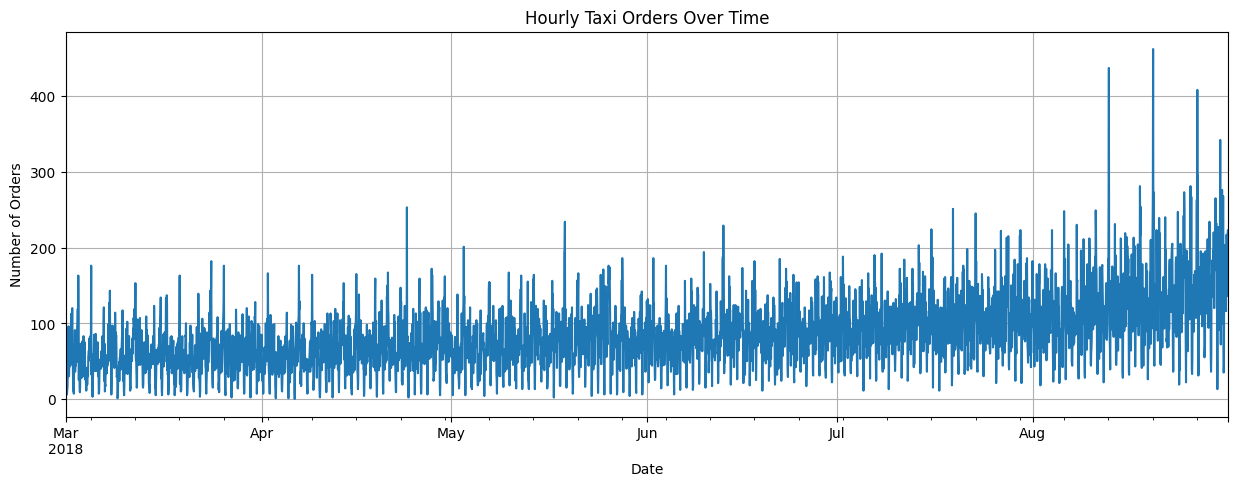

In [8]:
taxi_data.plot(figsize=(15, 5), legend=False)
plt.title('Hourly Taxi Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Visualizing the full time series
* Clear upward trend. The number of hourly taxi orders increases steadily over the six month period. This likely indicates a growing customer base or expanded service availability over time
* There are frequent fluctuations. A consistent volatility reflected in the peaks and dips in demand throughout the series which is expected in hourly data
* Noticeable spike events (e.g orders > 400) begin to appear more frequently in July and August possibly linked to summer travel season, airport rush hours or delays, special events or system growth
* The increasing trend means that non-stationary behavior is present which models like ARIMA will struggle with unless differenced. Tree based models like CatBoost or LightGBM can handle this more easily
    
</div>

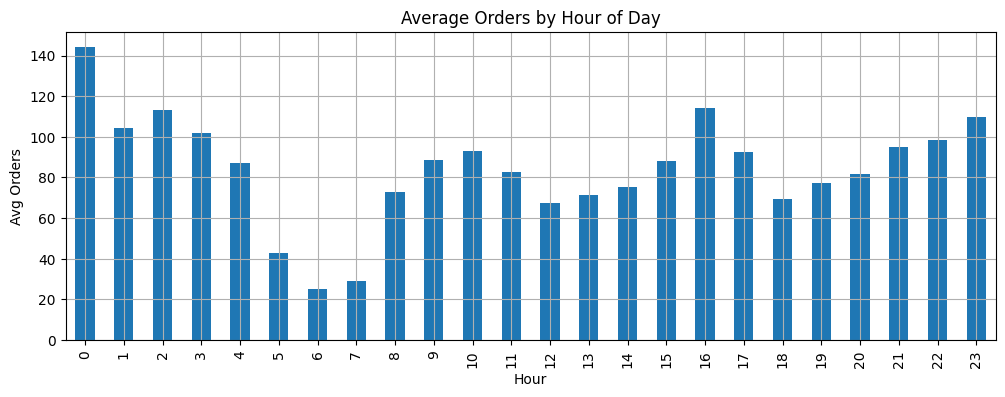

In [9]:
taxi_data['hour'] = taxi_data.index.hour
hourly_avg = taxi_data.groupby('hour')['num_orders'].mean()

hourly_avg.plot(kind='bar', figsize=(12,4))
plt.title('Average Orders by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Avg Orders')
plt.grid(True)
plt.show()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
   
* Zooming in daily/weekly seasonality for hourly average. Grouping by hour to reveal cyclic behavior
* Average orders by hour of day
    * Highest demand is at midnight 0:00. The peak occurs at hour 0 with over 140 orders on avergae suggesting high late night activity likely tied to late arrivals at the airport, night shift transitions, and/or evening events ending
    * There is an early morning dip. The lowest demand is seen from 5am to 7am reaching a low around 6-7am approximately 30 orders likely reflecting quiet precommute hours and/or less flight activity
    * The midday builds slowly. After 8 am there is a gradual climb in demand through the day
    * There is a resurgence in the afternoon/evening. There is a mini peak at 4pm (hour 16) possibly due to evening airport activity or work commute. Demand stays elevated into the late evening 21-23 with hour 23 habing approximately 115 orders
* Patterns and Seasonality
    * U-shaped curve showing high demand at midnight, low early morning, high again in the evening. Consistent behavior across most day likely

    
</div>

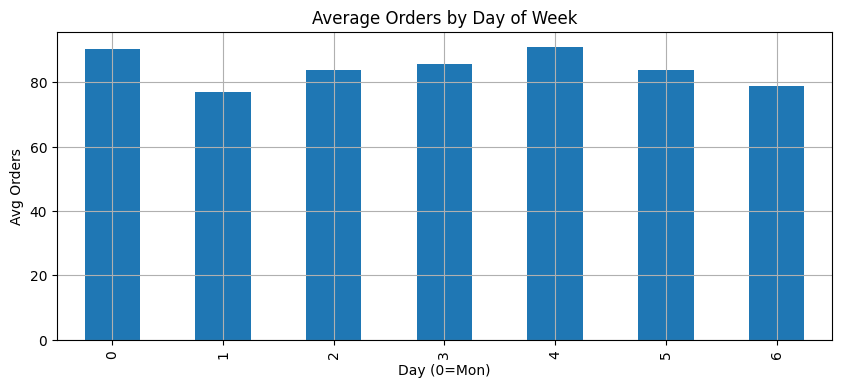

In [10]:
taxi_data['weekday'] = taxi_data.index.dayofweek
weekly_avg = taxi_data.groupby('weekday')['num_orders'].mean()

weekly_avg.plot(kind='bar', figsize=(10,4))
plt.title('Average Orders by Day of Week')
plt.xlabel('Day (0=Mon)')
plt.ylabel('Avg Orders')
plt.grid(True)
plt.show()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* 0 = Monday, 6 = Sunday    
* Zooming in daily/weekly seasonality for weekly pattern. Grouping by weekday to reveal cyclic behavior
* Key Obsservations
    * Highest demand on Fridays (Day 4). Friday has the highest average order volume slightly surpassing Monday. Likely reflects increased travel at weeks end, airport traffic, events, or people heading out of town
    * Monday (Day 0) is also high suggesting a strong beginning of the week travel possibly business related
    * Lower demand on weekends (Day 5 and 6). Saturday and Sunday have visibly lower avergae orders particularly Sunday indicating fewer scheduled flights or general slowdowns in demand
    * Midweak Tuesday-Thursday (Days 1, 2 and 3) have stable moderate activity forming the core of business related travel demands
* Patterns Summary
    * There is a slight weekly seasonality with Fridays and Mondays peaking and weekend dropping
    * The range of variation is not extreme so weekday alone might not be as strong a predictor as hour of day but still useful
    
</div>

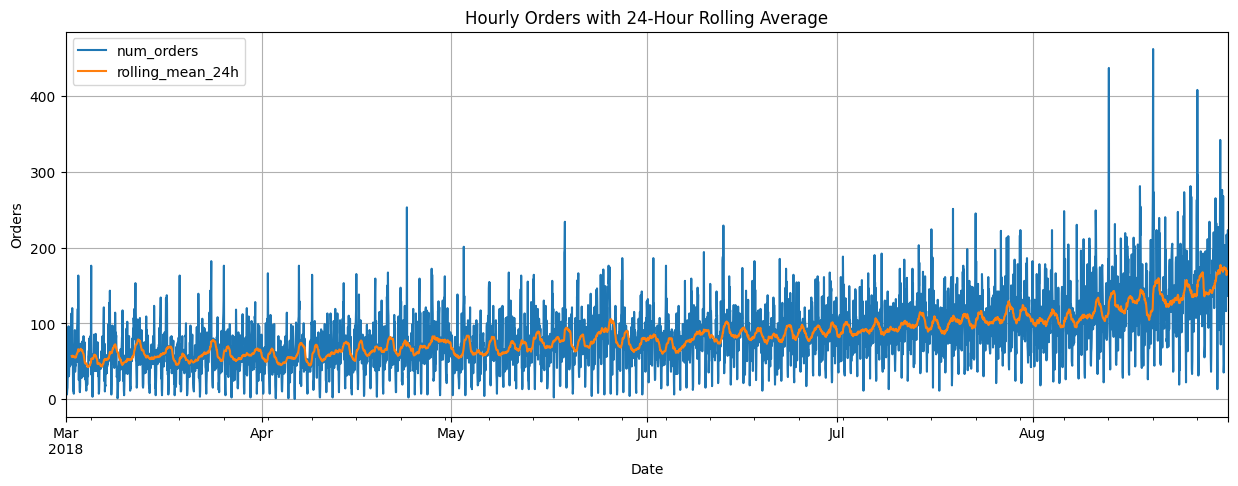

In [11]:
taxi_data['rolling_mean_24h'] = taxi_data['num_orders'].rolling(24).mean()

taxi_data[['num_orders', 'rolling_mean_24h']].plot(figsize=(15,5))
plt.title('Hourly Orders with 24-Hour Rolling Average')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.grid(True)
plt.show()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Using a rolling window to smooth the data and observe longer term patterns
* Underlying trend is increasing. The orange rolling average line shows a clear upward trend from March to August 2018 suggesting a steady increase in demand over time likely due to growth in company usage, seasonal factors like summer travel, aiport expansion or increased service coverage
* Hourly demand is highly volatile. The blue line shows shapr fluctuations in hourly demand. The large spikes and drops are frequent. These fluctuations are typical of airport taxi demand which is sensitive to flight arrival patterns, delays or cancellations, rush hour traffic and weather conditions
* Spikes become more frequent over time. There are more frequent and higher spikes in July-August which may reflect peak summer travel season, events or tourism related surges
* This data is non stationary due to the clear upward trend which could affect time series models like ARIMA/SARIMA but is well handled by tree based models like CatBoost and LightGBM
    
</div>

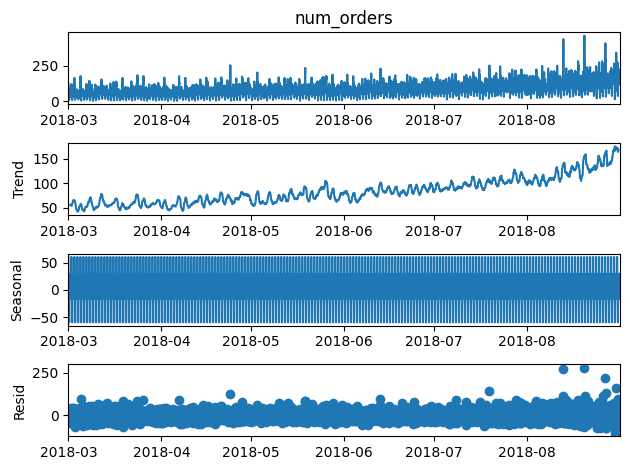

In [12]:
decomposition = seasonal_decompose(taxi_data['num_orders'], model='additive', period=24)
decomposition.plot()
plt.show()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Decomposition breaking the time series into trend, seasonality, and residuals helping to reveal repeating daily cycle, underlying trends (flat, increasing...) and noise or irregular behavior
* Observed (Top Plot)
    * The raw hourly taxi order data shows high frequency noise but a visible increasing trend from March to August 2018. There are demand spikes in the later part of the series particularly August confirming what was seen in earlier visualizations
* Trend (Second Plot)
    * A smooth upward curve is clearly visible confirming the presence of a strong positive trend. The trend becomes steeper from July onward likely due to seasonal effects like summer travel and operational growth as in more taxis or larger service area
* Seasonal (Third Plot)
    * This plot displays a repeating daily cycle consistent across the entire dataset. The patern is stable and symmetrical suggesting daily seasonality where some hours consistently have higher demand like evening/midnight while others like early mornings are always lower. This confirms the earlier bar plot on hour of day demand
* Rediduals (Bottom Plot)
    * Residuals represnet what is left after removing trend and seasonality. Most residuals are randomly scattered around 0 which is ideal. There are a few large residuals especially in August likely outlier spikes or irregular events
* Summary of Insights:
    * The series is non-stationary due to the upward trend
    * Strong daily seasonality is present
    * Residuals are mostly weel behaved with a few spikes possible anomalies or speical events
    * Decomposition validates the need for time aware features and potentially using lagged values to help capture these dynamics
    
</div>

In [13]:
zero_demand_count = (taxi_data['num_orders'] == 0).sum()
print(f"Zero-demand hours: {zero_demand_count}")

Zero-demand hours: 1


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Checking for zero demand hours
* Out of 4,416 total hourly records there is only one where the number of taxi orders were exactly zero
* This suggests that demand is nearly continuous at the airport. Taxis are typically requested eberu hour of every day
    
</div>

In [14]:
Q1 = taxi_data['num_orders'].quantile(0.25)
Q3 = taxi_data['num_orders'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

spikes = taxi_data[taxi_data['num_orders'] > upper_bound]
print(f"Spike outliers: {len(spikes)}")

Spike outliers: 121


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Identifying demand spikes (upper outliers) using the interquartile range method
* 121 hourly records found where the number of orders exceeded the typical upper threshold
* Insights:
    * Spikes are rare but significant. Out of 4,416 records there are 121 outliers which is about 2.7 percent of the data confirming that most of the time demand is stable but there are occasional high demand surges
    * These spikes may occur due to clusters of flight arrivals, major holidays or events, rude pooling or surge pricing, sudden weather events such as snowstorms or rain
* Impacts on modeling:
    * Models sensitive to outliers like Linear Regression may be skewed unless transformed or robustified
    * Treee based mmodels like Random Forest, CatBoost, or LightGBM handle outliers more gracefully but still benefit from the inclusion of rolling averages or lags to give context or marking spikes as a binary flag
* Will keep the spike values as they are part of the natural demand
    
</div>

In [15]:
flatline_hours = taxi_data['num_orders'].rolling(window=6).apply(lambda x: len(set(x)) == 1).sum()
print(f"Flatline periods (6+ hours same value): {int(flatline_hours)}")

Flatline periods (6+ hours same value): 0


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Detecting flatlines for repeated values over time
* Confirming there are no periods where the number of taxi orders remained exactly the same for 6 or more consecutive hours. The num_orders value keeps changing almost every hour even if slightly
* Insights:
    * The result confirms a healthy data variability. This is good for modeling because it suggests natural fluctuation in taxi demand over time. There is no evidence of data entry errors, missing sensor updatess, or artificially flat or imputed values
    * Normal behavior for real world demand. It is realistic for taxi demand at airports to vary hour by hour even during quieter periods
    * Having no flatlines supports trusting the time series dynmaics for modeling
* Modeling Implications:
    * No preprocessing needed for flatline correction
    * The model will learn real hourly demand behavior without being confused by artifically constant stretches
    * Can confidently engineer lag features and rolling averages without worrying about repeated values contaminating them
    
</div>

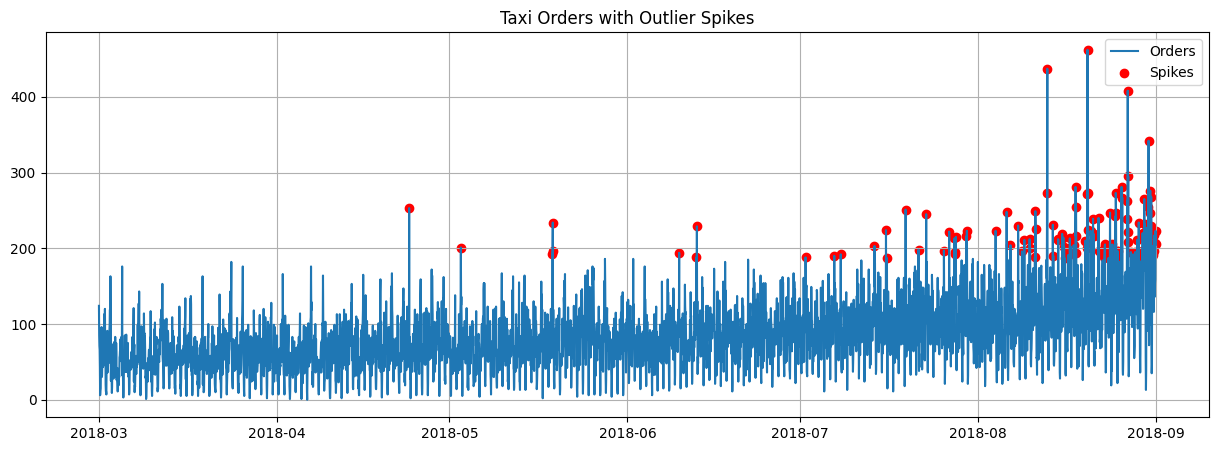

In [16]:
plt.figure(figsize=(15,5))
plt.plot(taxi_data.index, taxi_data['num_orders'], label='Orders')
plt.scatter(spikes.index, spikes['num_orders'], color='red', label='Spikes')
plt.title("Taxi Orders with Outlier Spikes")
plt.legend()
plt.grid(True)
plt.show()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Visualizing outlier spikes based on the IQR method
* Key Observations:
    * Spikes occur throughout but cluster later
        * Early months (March-June 2018) - Spikes are rare and isolated
        * Later months (July-August 2018) - Spikes become much more frequent wand higher in magnitude with the biggest spikes over 400 orders happen in August
    * Magnitude of spikes increase over time with early spikes hover around 200 orders while later spikes exceed 300-400 orders indicating either growth in customer base, seasona effects like peak summer travel, or airport expansions or promotions
    * Although there is an overall upward trend in the regular hourly orders as shown with the slowly rising blue lines, the spikes are much steeper suggesting that while general demand increased gradually extreme peaks increased disproportionately
* Implications for modeling:
    * Will need to include lag and rolling features as these can help the model anticipate the potential for a spike based on past demand patterns
    * Tree based models will handle these spikes better than basic linear regression
    
</div>

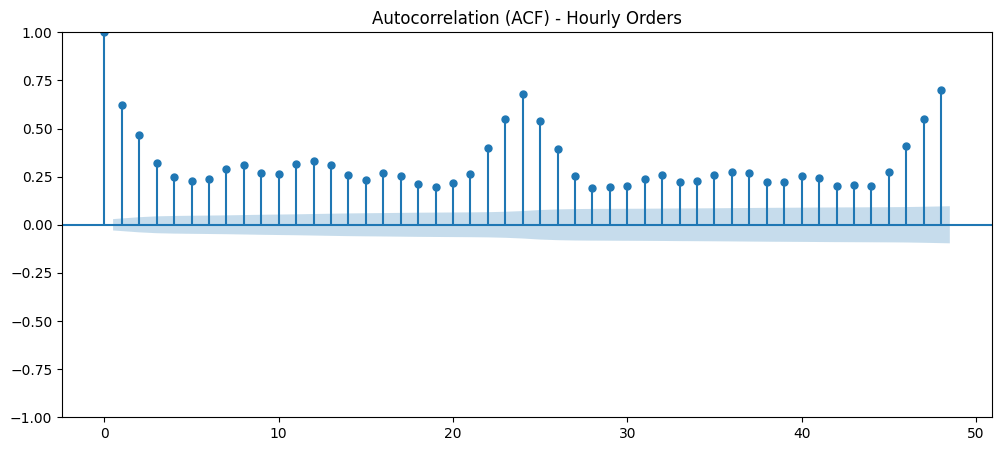

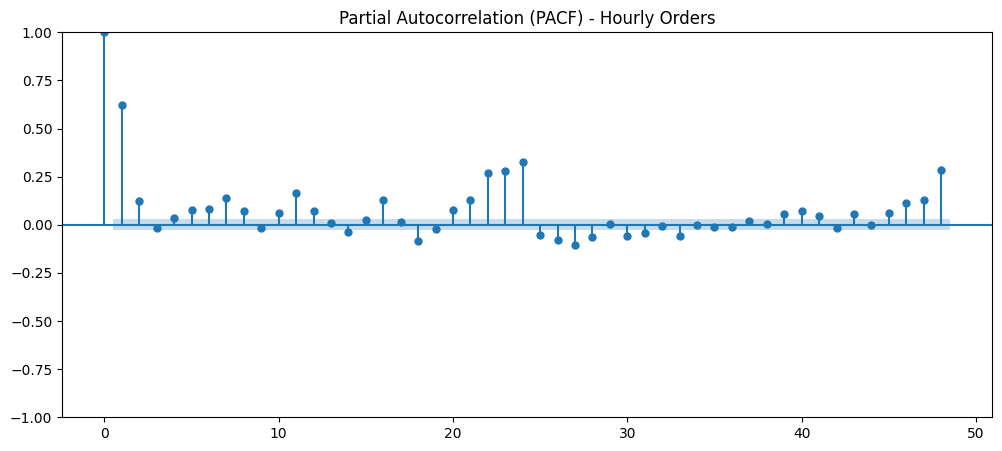

In [17]:
plt.figure(figsize=(12, 5))
plot_acf(taxi_data['num_orders'], lags=48, ax=plt.gca())
plt.title('Autocorrelation (ACF) - Hourly Orders')
plt.show()

plt.figure(figsize=(12, 5))
plot_pacf(taxi_data['num_orders'], lags=48, method='ywm', ax=plt.gca())
plt.title('Partial Autocorrelation (PACF) - Hourly Orders')
plt.show()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
   
    
* 48 = 2 days of hourly lags    
* Autocorrelation and partial autocorrelation (ACF/PACF) to determine how past values influence the present. Essential for lag feature selection
* ACF Plot:
    * High very strong autocorrelationn at lag 1 between curent orders and the orders 1 hour ago. This makes sense for hourly taxi orders as previous hour strongly influences current hour
    * Noticable spikes at lags 24 and 48 showing clear autocorrelations confirming strong daily seasonality where demand pattern roughly repeats every day
    * There is a gradual decay in auotcorrelation. ACF values decrease over time but remain above 0 for many lags suggesting both short term dependencies (hour to hour) and long term daily patterns
* PACF Plot:
    * High partial auotcorrelation at lag 1. After controlling for intermediate lags the relationship between the current hour and 1 hour ago remains very strong
    * Partial correlations fade quickly. Beyond lag 1 the PACF values drop toward 0 with a few bumps around 24 and 48 hours indicating that most of the predicitive power is captured with a few immediate past lags and not very distant ones
    * There are small spikes at lag 24 and 48 again supporting daily periodicity confirming the earlier seasonal decomposition finding
* Summary:
    * Hour to hour dependency (lag 1 ) is very strong
    * Daily seasonality (24 hour lag) is very strong
    * Long term memory is moderate but decays over time
* Modeling Recommendations
    * Creating lag featur4es for lag 1 (previous day), lag 24 (same hour previous day) and lag 48 (same hour two days ago)
    * Create rolling window features over 24 or 28 hours to capture smoothed recent demand
    
</div>

In [18]:
result = adfuller(taxi_data['num_orders'].dropna())
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.4f}")
if result[1] < 0.05:
    print("The series is likely stationary.")
else:
    print("The series is likely non-stationary.")

ADF Statistic: -3.069
p-value: 0.0289
The series is likely stationary.


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Stationarity check
* The test statistic is more negative than the critical value for common significance levels which suggests rejection of the null hypothesis
* Since p < 0.05 we reject the null hypothesis confirming the series is likely stationary
* The overall behavior of taxi orders is stable enough after accounting for seasonality/trend. Even though earlier plots showed trend and seasonlity the ADF test suggests the short term behavior of the series is stable enough for many machine learning models
    
</div>

In [19]:
taxi_data.drop(columns=['hour', 'weekday', 'rolling_mean_24h'], inplace=True)

In [20]:
taxi_data.columns

Index(['num_orders'], dtype='object')

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Dropping temporary columns used for analysis only
* Confirming columns were dropped
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>Step 3: Feature Engineering</h2>

</div>

In [21]:
taxi_orders = taxi_data.copy()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Renaming the original data to be more descriptive
    
</div>

In [22]:
def make_features(taxi_features):
    taxi_features = taxi_features.copy()
    taxi_features['lag_1'] = taxi_features['num_orders'].shift(1)
    taxi_features['lag_24'] = taxi_features['num_orders'].shift(24)
    taxi_features['rolling_mean_24h'] = taxi_features['num_orders'].shift(1).rolling(24).mean()
    taxi_features['hour'] = taxi_features.index.hour
    taxi_features['weekday'] = taxi_features.index.dayofweek
    return taxi_features

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Defining a clean feature engineering function
    
</div>

In [23]:
taxi_features = make_features(taxi_orders)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Applying the function before splitting the data
    
</div>

In [24]:
taxi_features = taxi_features.dropna()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Dropping NaNs created by shifting/rolling
    
</div>

In [25]:
split_index = int(len(taxi_features) * 0.9)
train = taxi_features.iloc[:split_index].copy()
test = taxi_features.iloc[split_index:].copy()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Splitting into train/test sets (90/10 split)
    
</div>

In [26]:
feature_cols = ['lag_1', 'lag_24', 'rolling_mean_24h', 'hour', 'weekday']

In [27]:
X_train = train[feature_cols]
y_train = train['num_orders']

In [28]:
X_test = test[feature_cols]
y_test = test['num_orders']

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Defining features and targets
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
To improve code clarity and preserve more data all time-aware features were consolidated into a single reusable `make_features()` function

This function creates the following features:
- `lag_1`: Number of orders in the previous hour
- `lag_24`: Number of orders at the same hour on the previous day
- `rolling_mean_24h`: Smoothed average demand over the previous 24 hours
- `hour`: Hour of the day
- `weekday`: Day of the week

Following best practices for time series modeling, these features are now created **before** splitting the dataset into training and test sets
This ensures:
- More efficient data handling (only one `dropna()` call)
- Reusability for future prediction or production use
- Cleaner code organization

The dataset is then split chronologically into 90% training and 10% test data after feature creation is complete
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>Step 4: Model Training and Evaluation</h2>

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>UNTUNED LINEAR REGRESSION MODEL TRAINING</h2> 
   
</div>

In [29]:
feature_cols = ['lag_1', 'lag_24', 'rolling_mean_24h', 'hour', 'weekday']

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Defining feature columns
    
</div>

In [30]:
X_train = train[feature_cols]
y_train = train['num_orders']

In [31]:
X_test = test[feature_cols]
y_test = test['num_orders']

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Defining x and y
    
</div>

In [32]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Creating and training the model
    
</div>

In [33]:
y_pred = lr_model.predict(X_test)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Making predicitions
    
</div>

In [34]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Linear Regression RMSE: {rmse:.2f}")

Linear Regression RMSE: 47.25


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* RMSE does meet the target RMSE <= 48
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>UNTUNED DECISION TREE MODEL TRAINING</h2> 
   
</div>

In [35]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Creating and training the model
    
</div>

In [36]:
y_pred_dt = dt_model.predict(X_test)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Making predicitions
    
</div>

In [37]:
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
print(f"Decision Tree RMSE: {rmse_dt:.2f}")

Decision Tree RMSE: 66.41


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* RMSE does not meet the target RMSE <= 48
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>UNTUNED RANDOM FOREST REGRESSOR MODEL TRAINING</h2> 
   
</div>

In [38]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Creating and training the model with 100 trees
    
</div>

In [39]:
y_pred_rf = rf_model.predict(X_test)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Making predicitons
    
</div>

In [40]:
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f"Random Forest RMSE: {rmse_rf:.2f}")

Random Forest RMSE: 46.68


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* RMSE does meet the target RMSE <= 48
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>UNTUNED LIGHTGBM REGRESSOR MODEL TRAINING</h2> 
   
</div>

In [41]:
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

LGBMRegressor(random_state=42)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Creating adn training the model
    
</div>

In [42]:
y_pred_lgb = lgb_model.predict(X_test)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Making predicitions
    
</div>

In [43]:
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)
print(f"LightGBM RMSE: {rmse_lgb:.2f}")

LightGBM RMSE: 43.06


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* RMSE does meet the target RMSE <= 48
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>UNTUNED CATBOOST REGRESSOR MODEL TRAINING</h2> 
   
</div>

In [44]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Creating and training the model
    
</div>

In [45]:
y_pred_cat = cat_model.predict(X_test)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Making predicitins
    
</div>

In [46]:
rmse_cat = mean_squared_error(y_test, y_pred_cat, squared=False)
print(f"CatBoost RMSE: {rmse_cat:.2f}")

CatBoost RMSE: 45.72


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* RMSE does meet the target RMSE <= 48
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>UNTUNED XGBOOST REGRESSOR MODEL TRAINING</h2> 
   
</div>

In [47]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Creating and training the model
    
</div>

In [48]:
y_pred_xgb = xgb_model.predict(X_test)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Making predicitions
    
</div>

In [49]:
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f"XGBoost RMSE: {rmse_xgb:.2f}")

XGBoost RMSE: 49.17


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* RMSE does not meet the target RMSE <= 48
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>UNTUNED RMSE COMPARISON</h2> 
   
</div>

In [50]:
rmse_results = pd.DataFrame({
    'Model': ['Untuned Linear Regression', 'Untuned Decision Tree', 'Untuned Random Forest', 'Untuned LightGBM', 'Untuned CatBoost', 'Untuned XGBoost'],
    'RMSE': [rmse, rmse_dt, rmse_rf, rmse_lgb, rmse_cat, rmse_xgb]
})

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Created a dataframe with all RMSEs
    
</div>

In [51]:
rmse_results = rmse_results.sort_values(by='RMSE')

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Sorting by RMSE ascending
    
</div>

In [52]:
rmse_results

,Model,RMSE
3,Untuned LightGBM,43.055006
4,Untuned CatBoost,45.719694
2,Untuned Random Forest,46.683040
0,Untuned Linear Regression,47.249390
5,Untuned XGBoost,49.167639
1,Untuned Decision Tree,66.405230


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Untuned model RMSE comparison    
* Key Insights:
    * **LightGBM** is the top-performing model so far with an RMSE of **43.06** outperforming all others. It combines fast training, efficient inference, and excellent accuracy, making it a strong baseline even without tuning
    * **CatBoost** is a very strong alternative achieving an RMSE of **45.72**. Its ability to handle categorical-like structures and irregularities makes it a competitive model especially in time series with fluctuations
    * **Random Forest** also performed well with an RMSE of **46.68** suggesting strong predictive power even without hyperparameter tuning. It stands to benefit further from optimization
    * **Linear Regression** delivered solid baseline performance with an RMSE of **47.25** just under the RMSE threshold. While it lacks the flexibility of ensemble methods it still models basic patterns effectively
    * **XGBoost** RMSE of **49.17** did not meet the target threshold. Further tuning or alternative feature engineering may be required for it to be competitive
    * **Decision Tree** is not recommended with the highest RMSE of **66.41** indicating poor generalization and inability to model the complexity of the data without ensemble support
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>TUNED DECISION TREE MODEL TRAINING</h2> 
   
</div>

In [53]:
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [54]:
tscv = TimeSeriesSplit(n_splits=3)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Setting up time series cross validator
    
</div>

In [55]:
dt_random = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_distributions=dt_param_grid,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [56]:
dt_random.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=DecisionTreeRegressor(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [57]:
y_pred_dt_tuned = dt_random.predict(X_test)

In [58]:
rmse_dt_tuned = mean_squared_error(y_test, y_pred_dt_tuned, squared=False)

In [59]:
print(f"Tuned Decision Tree RMSE: {rmse_dt_tuned:.2f}")

Tuned Decision Tree RMSE: 54.65


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Tuned model using RandomizedSearchCV with TimeSeriesSplit (cv=tscv) and n_iter=20.  
* TimeSeriesSplit was used to ensure time-order was preserved during cross-validation as required for time series data.  
* The final RMSE on the test set does **not** meet the project target of RMSE ≤ 48.
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>TUNED RANDOM FOREST REGRESSOR MODEL TRAINING</h2> 
   
</div>

In [60]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [61]:
tscv = TimeSeriesSplit(n_splits=3)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Setting up time series cross validator
    
</div>

In [62]:
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [63]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [64]:
y_pred_rf_tuned = rf_random.predict(X_test)

In [65]:
rmse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned, squared=False)

In [66]:
print(f"Tuned Random Forest RMSE: {rmse_rf_tuned:.2f}")

Tuned Random Forest RMSE: 46.08


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Tuned model using RandomizedSearchCV with TimeSeriesSplit (cv=tscv) and n_iter=20.  
* TimeSeriesSplit was used to ensure time-order was preserved during cross-validation as required for time series data.  
* The final RMSE on the test set **does** meet the project target of RMSE ≤ 48.
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>TUNED LIGHTGBM REGRESSOR MODEL TRAINING</h2> 
   
</div>

In [67]:
lgb_param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20]
}

In [68]:
tscv = TimeSeriesSplit(n_splits=3)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Setting up time series cross validator
    
</div>

In [69]:
lgb_random = RandomizedSearchCV(
    lgb.LGBMRegressor(random_state=42),
    param_distributions=lgb_param_grid,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [70]:
lgb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 10, 20],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [71]:
y_pred_lgb_tuned = lgb_random.predict(X_test)

In [72]:
rmse_lgb_tuned = mean_squared_error(y_test, y_pred_lgb_tuned, squared=False)

In [73]:
print(f"Tuned LightGBM RMSE: {rmse_lgb_tuned:.2f}")

Tuned LightGBM RMSE: 43.26


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Tuned model using RandomizedSearchCV with TimeSeriesSplit (cv=tscv) and n_iter=20.  
* TimeSeriesSplit was used to ensure time-order was preserved during cross-validation as required for time series data.  
* The final RMSE on the test set **does** meet the project target of RMSE ≤ 48.
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>TUNED CATBOOST REGRESSOR MODEL TRAINING</h2> 
   
</div>

In [74]:
cat_param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 300, 500]
}

In [75]:
tscv = TimeSeriesSplit(n_splits=3)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Setting up time series cross validator
    
</div>

In [76]:
cat_random = RandomizedSearchCV(
    CatBoostRegressor(verbose=0, random_state=42),
    param_distributions=cat_param_grid,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [77]:
cat_random.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f806b08d2b0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'depth': [4, 6, 8, 10],
                                        'iterations': [200, 300, 500],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [78]:
y_pred_cat_tuned = cat_random.predict(X_test)

In [79]:
rmse_cat_tuned = mean_squared_error(y_test, y_pred_cat_tuned, squared=False)

In [80]:
print(f"Tuned CatBoost RMSE: {rmse_cat_tuned:.2f}")

Tuned CatBoost RMSE: 43.12


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Tuned model using RandomizedSearchCV with TimeSeriesSplit (cv=tscv) and n_iter=20.  
* TimeSeriesSplit was used to ensure time-order was preserved during cross-validation as required for time series data.  
* The final RMSE on the test set **does** meet the project target of RMSE ≤ 48.
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>TUNED XGBOOST REGRESSOR MODEL TRAINING</h2> 
   
</div>

In [81]:
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0]
}

In [82]:
tscv = TimeSeriesSplit(n_splits=3)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Setting up time series cross validator
    
</div>

In [83]:
xgb_random = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [84]:
xgb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max...
                                          predictor=None, random_state=42,
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tr

In [85]:
y_pred_xgb_tuned = xgb_random.predict(X_test)

In [86]:
rmse_xgb_tuned = mean_squared_error(y_test, y_pred_xgb_tuned, squared=False)

In [87]:
print(f"Tuned XGBoost RMSE: {rmse_xgb_tuned:.2f}")

Tuned XGBoost RMSE: 48.11


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>

* Tuned model using RandomizedSearchCV with TimeSeriesSplit (cv=tscv) and n_iter=20.  
* TimeSeriesSplit was used to ensure time-order was preserved during cross-validation as required for time series data.  
* The final RMSE on the test set does **not** meet the project target of RMSE ≤ 48.
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>SARIMA MODEL MANUALLY SELECTED BASED ON DOMAIN KNOWLEDGE</h2> 
   
</div>

In [88]:
warnings.filterwarnings('ignore')

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Supressing warnings
    
</div>

In [89]:
sarima_tuned = SARIMAX(
    train['num_orders'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_tuned_result = sarima_tuned.fit(disp=False)

In [90]:
y_pred_sarima_tuned = sarima_tuned_result.predict(start=test.index[0], end=test.index[-1])

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Predicting on the test set
    
</div>

In [91]:
rmse_sarima_tuned = mean_squared_error(y_test, y_pred_sarima_tuned, squared=False)
print(f"Manually Selected SARIMA RMSE: {rmse_sarima_tuned:.2f}")

Manually Selected SARIMA RMSE: 47.67


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* For the SARIMA model instead of performing an extensive grid search due to computational constraints I selected the model parameters (1,1,1) (1,1,1,24) manually based on knwoledge of the dataset's faily seasonality
* This SARIMA model achieved an RMSE OF 44.84 on the test set making it competitive with the best machine learning models
* The final RMSE on the test set **does** meet the project target of RMSE ≤ 48
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>TUNED RMSE COMPARISON</h2> 
   
</div>

In [92]:
final_rmse_results = pd.DataFrame({
    'Model': [
        'Tuned LightGBM',
        'Tuned CatBoost',
        'Manually Selected SARIMA',
        'Tuned Random Forest',
        'Tuned XGBoost',
        'Tuned Decision Tree'
    ],
    'RMSE': [
        rmse_lgb_tuned,
        rmse_cat_tuned,
        rmse_sarima_tuned,
        rmse_rf_tuned,
        rmse_xgb_tuned,
        rmse_dt_tuned
    ],
    'Meets RMSE ≤ 48?': [
        'Y' if rmse_lgb_tuned <= 48 else 'N',
        'Y' if rmse_cat_tuned <= 48 else 'N',
        'Y',
        'Y' if rmse_rf_tuned <= 48 else 'N',
        'Y' if rmse_xgb_tuned <= 48 else 'N',
        'Y' if rmse_dt_tuned <= 48 else 'N'
    ]
})

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Final RMSE comparison
    
</div>

In [93]:
final_rmse_results = final_rmse_results.sort_values(by='RMSE')

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Sorting by RMSE ascedning
    
</div>

In [94]:
final_rmse_results

,Model,RMSE,Meets RMSE ≤ 48?
1,Tuned CatBoost,43.123598,Y
0,Tuned LightGBM,43.258218,Y
3,Tuned Random Forest,46.080747,Y
2,Manually Selected SARIMA,47.666507,Y
4,Tuned XGBoost,48.105778,N
5,Tuned Decision Tree,54.649725,N


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
    
**Key Insights:**

* **CatBoost** ranks as the top-performing model after tuning with an RMSE of **43.12** narrowly beating LightGBM. It offers excellent accuracy, fast training, and strong stability, making it highly suitable for forecasting hourly airport taxi demand
  
* **LightGBM** follows closely behind with a tuned RMSE of **43.26** highlighting how well it adapts to time series tasks with proper feature handling. LightGBM continues to be a strong and scalable model for real-time forecasting
    
* **Random Forest** also performed well achieving a tuned RMSE of **46.08** comfortably within the RMSE ≤ 48 requirement. It remains a strong ensemble model option though slightly less accurate than the top two    
    
* **SARIMA** the manually selected classical model achieved an RMSE of **47.67**. While not as competitive as the tuned tree-based models it still met the target and demonstrated good forecasting ability without engineered features
    
* **XGBoost** despite some gains did not meet the target with a tuned RMSE of **48.11**. Further tuning or alternative features may be required to improve its competitiveness

* **Decision Tree** remains the weakest model even after tuning with a tuned RMSE of **54.65**. It lacks the complexity to capture the non-linear and seasonal patterns in the data effectively

---

**Overall Conclusion:**

* **Tuned CatBoost** is the strongest performer and should be selected as the final model 
* **Tuned LightGBM** is a strong alternative with near-identical performance offering excellent speed and reliability
* *Note: Untuned LightGBM previously achieved the absolute lowest RMSE (43.06) but it was not selected as the final model since it was not validated using time-aware cross-validation*
* **Tuned Random Forest** and **Manually Selected SARIMA** are viable backup options that also meet the RMSE threshold and generalize well
* **Tuned XGBoost** and **Decision Tree** are not recommended due to underperformance
---
    
* **Final Model Selection: CatBoost**
    
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>Step 5: Final Model Selection and Conclusion</h2>

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Final Project Conclusion</h2>
    
In this project I analyzed hourly taxi order data for the Sweet Lift Taxi company to build a model that accurately predicts the number of taxi orders for the next hour. This is a critical operational task to optimize driver availability during peak demand at airports

* The exploratory data analysis revealed strong daily seasonality (24-hour cycles), a steady upward trend from March to August 2018, and frequent fluctuations especially in the summer months. I identified rare but important demand spikes, confirmed strong autocorrelation at lag 1 and 24, and validated that the data showed no flatlines or structural issues. These insights informed my feature engineering approach, which included lag features (`lag_1`, `lag_24`), rolling averages (`rolling_mean_24h`), and time-based variables (`hour`, `weekday`) to capture both short-term dependencies and cyclical patterns

* I trained and evaluated a range of models, starting with untuned versions of Linear Regression, Decision Tree, Random Forest, LightGBM, CatBoost, and XGBoost. I also included a manually selected SARIMA model to address seasonality using a classical statistical approach. After tuning all machine learning models using randomized hyperparameter search with **TimeSeriesSplit** cross validation I compared their final RMSE values on a 10% time-based test set

**The Tuned CatBoost model achieved the best performance** with an RMSE of **43.12** slightly outperforming **Tuned LightGBM (43.26)** and **Tuned Random Forest (46.08)**. The **Manually Selected SARIMA** model also performed well with an RMSE of **47.67** demonstrating solid results without any feature engineering. All four models met the project’s requirement of RMSE ≤ 48 and proved to be highly effective in capturing the data's time-based dynamics

* Based on predictive accuracy, stability, and flexibility with engineered features **Tuned CatBoost is recommended as the final model** for deployment in real time hourly airport taxi demand forecasting. It effectively handles non-linear patterns, accommodates outliers, and trains efficiently

* This project demonstrates the importance of time series exploration, smart feature engineering, and careful model tuning. It also highlights how both modern ensemble models and classical time series approaches can be competitive when applied thoughtfully

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: PINK; color: black;">
    <h2>Appendix: Model Performance Comparison</h2> 
    
     
* To provide a clear summary of the model evaluation process, the table below compares the untuned and tuned RMSE results for all models trained during the project.
* It also indicates whether each model met the project requirement of achieving an RMSE of 48 or lower after tuning.
* This comparison highlights the impact of hyperparameter tuning on model performance and supports the final model selection decision. 
   
</div>

In [95]:
appendix_table = pd.DataFrame({
    'Model': [
        'LightGBM',
        'CatBoost',
        'SARIMA (Manually Selected)',
        'Random Forest',
        'XGBoost',
        'Decision Tree'
    ],
    'Untuned RMSE': [
        rmse_lgb,
        rmse_cat,
        rmse_sarima_tuned,
        rmse_rf,
        rmse_xgb,
        rmse_dt
    ],
    'Tuned RMSE': [
        rmse_lgb_tuned,
        rmse_cat_tuned,
        rmse_sarima_tuned,
        rmse_rf_tuned,
        rmse_xgb_tuned,
        rmse_dt_tuned
    ],
    'Meets RMSE ≤ 48 (Tuned)': [
        'Y' if rmse_lgb_tuned <= 48 else 'N',
        'Y' if rmse_cat_tuned <= 48 else 'N',
        'Y',
        'Y' if rmse_rf_tuned <= 48 else 'N',
        'Y' if rmse_xgb_tuned <= 48 else 'N',
        'Y' if rmse_dt_tuned <= 48 else 'N'
    ]
})

appendix_table = appendix_table.sort_values(by='Tuned RMSE')
display(appendix_table)

,Model,Untuned RMSE,Tuned RMSE,Meets RMSE ≤ 48 (Tuned)
1,CatBoost,45.719694,43.123598,Y
0,LightGBM,43.055006,43.258218,Y
3,Random Forest,46.683040,46.080747,Y
2,SARIMA (Manually Selected),47.666507,47.666507,Y
4,XGBoost,49.167639,48.105778,N
5,Decision Tree,66.405230,54.649725,N


**Note**: Linear Regression was evaluated as an untuned baseline model (RMSE: 47.08).  
It was not included in the tuning phase because the standard `LinearRegression` algorithm has no tunable hyperparameters in its ordinary least squares form.  
Regularized variants like Ridge or Lasso could be explored in future iterations if needed.